In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from functools import partial
np.set_printoptions(suppress=True)
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import binom

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
#tf.enable_eager_execution()

In [4]:
from deep_bayes.models import BayesFlow, InvariantNetwork
from deep_bayes.training import train_online
from deep_bayes.losses import maximum_likelihood_loss
from deep_bayes.viz import plot_true_est_scatter, plot_true_est_posterior

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Germany Data

In [6]:
confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
recovered_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
dead_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
vaccinated_url = 'https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/global_data/time_series_covid19_vaccine_global.csv'
symptomatic_data = './Klinische_Aspekte.csv'

confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
recovered_cases = pd.read_csv(recovered_cases_url, sep=',', dtype={"08/04/2021": np.float64})
dead_cases = pd.read_csv(dead_cases_url, sep=',')
vaccinations = pd.read_csv(vaccinated_url, sep = ',')
nonsymptomatic = np.array(pd.read_csv(symptomatic_data, sep = ';'))

date_data_begin = datetime.date(2021,1,1)
date_data_end = datetime.date(2021,8,1)


format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
format_percentage = lambda percentage: float('0.{}{}'.format(percentage[0:2], percentage[3]))

date_formatted_begin = format_date(date_data_begin)
date_formatted_end = format_date(date_data_end)

cases_obs =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]
recovered_obs =  np.array(
    recovered_cases.loc[recovered_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end], dtype = np.int64)[0]
dead_obs =  np.array(
    dead_cases.loc[dead_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]

# filter the vaccinations according to the start and end date
vaccinated = vaccinations[(vaccinations["Country_Region"] == "Germany") & 
                          (pd.to_datetime(vaccinations["Date"]) >= pd.to_datetime(date_data_begin)) &
                          (pd.to_datetime(vaccinations["Date"]) <= pd.to_datetime(date_data_end))]
# filter only the column of fully vaccinated persons
vaccinated = np.array(vaccinated)[:,4]
vaccinated = np.concatenate([np.zeros(cases_obs.shape[0] - vaccinated.shape[0]), vaccinated]).astype(int)

nonsymptomatic = nonsymptomatic[nonsymptomatic[:,0]=="2021", 7]
nonsymptomatic_rate = np.zeros(len(nonsymptomatic)*7)
for i in range(len(nonsymptomatic)):
    rate = format_percentage(nonsymptomatic[i])
    nonsymptomatic_rate[7*i:7*(i+1)] = [rate] *7

data_germany = np.stack([cases_obs, recovered_obs, dead_obs, vaccinated, np.zeros(len(cases_obs))]).T
data_germany = np.diff(data_germany, axis=0)
data_germany[:,4] = np.array(data_germany[:,0] * nonsymptomatic_rate[:data_germany.shape[0]], dtype='int32')
data_germany[:,0] = data_germany[:,0] - data_germany[:,4]

T = data_germany.shape[0]
N_germany = 83e6
mean_g = np.mean(data_germany, axis=0)
std_g = np.std(data_germany, axis=0)

R0 = recovered_obs[0]
D0 = dead_obs[0]
I0 = cases_obs[0] - R0 - D0

In [7]:
print(mean_g)

[  7970.23584906  10688.56603774    271.3254717  203836.69811321
   1537.5       ]


# Prior and Model

In [8]:
alpha_f = (0.7**2)*((1-0.7)/(0.17**2) - (1-0.7))
beta_f = alpha_f*(1/0.7 - 1)


def prior_sir():
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """
    t1 = np.random.normal(loc=150, scale=3)
    t2 = np.random.normal(loc=165, scale=3)
    t3 = np.random.normal(loc=180, scale=3)
    t4 = np.random.normal(loc=195, scale=1) 
    lambd0 = np.random.lognormal(mean=np.log(0.5), sigma=0.5)
    lambd1 = np.random.lognormal(mean=np.log(0.5), sigma=0.5)
    lambd2 = np.random.lognormal(mean=np.log(0.5), sigma=0.5)
    lambd3 = np.random.lognormal(mean=np.log(0.5), sigma=0.5)
    lambd4 = np.random.lognormal(mean=np.log(0.5), sigma=0.5)
    mu = np.random.lognormal(mean=np.log(1/8), sigma=0.2)
    mu_v = np.random.lognormal(mean=np.log(1/8), sigma=0.2)

    f_i = np.random.beta(a=alpha_f, b=beta_f)
    phi_i = stats.vonmises.rvs(0.01)
    f_r = np.random.beta(a=alpha_f, b=beta_f)
    phi_r = stats.vonmises(kappa=0.01).rvs()
    f_d = np.random.beta(a=alpha_f, b=beta_f)
    phi_d = stats.vonmises(kappa=0.01).rvs()
    f_v = np.random.beta(a=alpha_f, b=beta_f)
    phi_v = stats.vonmises(kappa=0.01).rvs()
    f_t = np.random.beta(a=alpha_f, b=beta_f)
    phi_t = stats.vonmises(kappa=0.01).rvs()

    D_i = np.random.lognormal(mean=np.log(8), sigma=0.2)
    D_r = np.random.lognormal(mean=np.log(8), sigma=0.2)
    D_d = np.random.lognormal(mean=np.log(8), sigma=0.2)
    D_v = np.random.lognormal(mean=np.log(8), sigma=0.2)
    D_t = np.random.lognormal(mean=np.log(8), sigma=0.2)

    E0 = np.random.gamma(shape=2, scale=37500)
    C0 = np.random.gamma(shape=2, scale=25000)
    scale_I = np.random.gamma(shape=1, scale=5)
    scale_R = np.random.gamma(shape=1, scale=5)
    scale_D = np.random.gamma(shape=1, scale=5)
    scale_V = np.random.gamma(shape=1, scale=5)
    scale_T = np.random.gamma(shape=1, scale=5)

    # vaccination rate
    v1 = np.random.lognormal(mean=np.log(0.0015), sigma=0.5)
    v2 = np.random.lognormal(mean=np.log(0.008), sigma=0.5)
    v3 = np.random.lognormal(mean=np.log(0.007), sigma=0.5)
    v4 = np.random.lognormal(mean=np.log(0.0015), sigma=0.5)

    return [t1, t2, t3, t4, 
            lambd0, lambd1, lambd2, lambd3, lambd4, mu, mu_v, 
            f_i, phi_i, f_r, phi_r, f_d, phi_d, f_v, phi_v, f_t, phi_t,
            D_i, D_r, D_d, D_v, D_t, E0, C0, 
            scale_I, scale_R, scale_D, scale_V, scale_T,
            v1, v2, v3, v4]


def prior_secir():
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """
    
    alpha = np.random.uniform(low=0.005, high=0.9)
    # probability to recover without symptoms if vaccinated
    alpha_v = np.random.uniform(low=0.005, high=0.9)
    beta = np.random.lognormal(mean=np.log(0.25), sigma=0.3)
    beta_v = np.random.lognormal(mean=np.log(0.25), sigma=0.3)
    gamma = np.random.lognormal(mean=np.log(1/6.5), sigma=0.5)
    eta = np.random.lognormal(mean=np.log(1/3.2), sigma=0.3)
    theta = np.random.uniform(low=1/14, high=1/3)
    delta = np.random.uniform(low=0.01, high=0.3)
    # probability of dying from a disease despite vaccination
    # source: illness after vacc.
    delta_v = np.random.uniform(low=0.003, high=0.2)
    d = np.random.uniform(low=1/14, high=1/3)
    # probability to get infected despite vaccination
    eps = np.random.lognormal(mean=np.log(0.1), sigma=0.1)
    # source: rki
    tau = np.random.lognormal(mean=np.log(0.02), sigma=0.5)
    return [alpha, alpha_v, beta, beta_v, gamma, eta, theta, delta, delta_v, d, eps, tau]


def calc_lambda_array(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4,
                      t1, t2, t3, t4,
                      v1, v2, v3, v4, T):
    """Computes the array of time-varying contact rates/transimission probabilities."""
    
    # Array of initial lambdas
    lambd0_arr = np.linspace(lambd0, lambd1, t1+sim_lag)
    v0_arr = np.linspace(0, v1, t1+sim_lag)
    
    # Compute lambd1 array
    lambd1_arr = np.linspace(lambd1, lambd2, t2-t1)
    v1_arr = np.linspace(v1, v2, t2-t1)
        
    # Compute lambd2 array
    lambd2_arr = np.linspace(lambd2, lambd3, t3-t2)
    v2_arr = np.linspace(v2, v3, t3-t2)

    # Compute lambd3 array
    lambd3_arr = np.linspace(lambd3, lambd4, t4-t3)
    v3_arr = np.linspace(v3, v4, t4-t3)
        
    # Compute lambd4 array
    lambd4_arr = np.array([lambd4] * (T-t4))
    v4_arr = np.array([v4] * (T-t4))
    
    return np.r_[lambd0_arr, lambd1_arr, lambd2_arr, lambd3_arr, lambd4_arr], np.r_[v0_arr, v1_arr, v2_arr, v3_arr, v4_arr]


def SECIR(params_sir, params_secir, N, T, sim_diff=32, observation_model=True, asymptomatic=False):
    """
    Performs a forward simulation from the stationary SIR model.
    """
    #print("Start forward simulation.")
    
    # Extract parameters 
    t1, t2, t3, t4, lambd0, lambd1, lambd2, lambd3, lambd4, mu, mu_v, f_i, phi_i, f_r, phi_r, f_d, phi_d, f_v, phi_v, f_t, phi_t, D_i, D_r, D_d, D_v, D_t, E0, C0, scale_I, scale_R, scale_D, scale_V, scale_T, v1, v2, v3, v4 = params_sir
    alpha, alpha_v, beta, beta_v, gamma, eta, theta, delta, delta_v, d, eps, tau = params_secir
    #print("Parameters calculated.")
    
    # Round integer parameters
    t1, t2, t3, t4 = int(round(t1)), int(round(t2)), int(round(t3)), int(round(t4))
    E0 = max(1, np.round(E0)) 
    C0 = max(1, np.round(C0))
    delay_i = int(round(D_i)) 
    delay_r = int(round(D_r)) 
    delay_d = int(round(D_d)) 
    delay_v = int(round(D_v))
    delay_t = int(round(D_t))

    # Impose constraints
    assert sim_diff > delay_i
    assert sim_diff > delay_r
    assert sim_diff > delay_d
    assert sim_diff > delay_v
    assert t1 > 0 and t2 > 0 and t3 > 0 and t4 > 0
    assert t1 < t2 < t3 < t4

    #print("Assertions passed")

    # Calculate lambda arrays
    # Lambda0 is the initial contact rate which will be consecutively
    # reduced via the government measures
    sim_lag = sim_diff - 1
    lambd_arr, v_arr = calc_lambda_array(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4,
                                         t1, t2, t3, t4, v1, v2, v3, v4, T)
    #print("Lambda array and v array calculated.")
 
    # Initial conditions
    S, E, C, I, R, D, PT, V, VE, VC, VI, VT = [N-E0-C0-I0-R0-D0], [E0], [C0], [I0], [R0], [D0], [0], [0], [0], [0], [0], [0]

    if asymptomatic:
        # Containers
        A_data = [0]
        S_data = [0]
    
    else:
        # Containers
        I_news = []
        R_news = []
        D_news = []
        V_news = []
        T_news = []
        
        # Reported new cases
        I_data = np.zeros(T)
        R_data = np.zeros(T)
        D_data = np.zeros(T)
        V_data = np.zeros(T)
        T_data = np.zeros(T)
        fs_i = np.zeros(T)
        fs_r = np.zeros(T)
        fs_d = np.zeros(T)
        fs_v = np.zeros(T)
        fs_t = np.zeros(T)

    # Simulate T-1 timesteps
    for t in range(T+sim_lag):
        
        # Calculate new exposed cases
        E_new = lambd_arr[t] * ((C[t] + VC[t] + beta*(I[t]+PT[t]) + beta_v*(VI[t]+VT[t]))/N)*S[t]

        # Calculate new exposed cases of vaccinated persons
        VE_new = eps * lambd_arr[t] * ((C[t] + VC[t] + beta*(I[t]+PT[t]) + beta_v*(VI[t]+VT[t]))/N)*V[t]

        # Calculate new vaccinated persons
        V_new = v_arr[t]*S[t]
    
        # Remove exposed from susceptible
        S_t = S[t] - E_new - V_new

        # Calculate all vaccinated persons
        V_t = V[t] + V_new - VE_new

        # Calculate exposed persons with vaccination
        VE_t = VE[t] + VE_new - gamma*VE[t]
        
        # Calculate current exposed by adding new exposed and
        # subtracting the exposed becoming carriers.
        E_t = E[t] + E_new - gamma*E[t]
        
        # Calculate current carriers by adding the new exposed and subtracting
        # those who will develop symptoms and become detected and those who
        # will go through the disease asymptomatically.
        C_t = C[t] + gamma*E[t] - (1-alpha)*eta*C[t] - alpha*tau*C[t] - alpha*theta*(1-tau)*C[t]

        # Calculate carriers that are vaccinated
        VC_t = VC[t] + gamma*VE[t] - (1-alpha_v)*eta*VC[t] - alpha_v*tau*VC[t] - alpha_v*theta*(1-tau)*VC[t]
        
        # Calculate current infected by adding the symptomatic carriers and 
        # subtracting the dead and recovered. The newly infected are just the 
        # carriers who get detected.
        I_t = I[t] + (1-alpha)*eta*C[t] - (1-delta)*mu*I[t] - delta*d*I[t]
        # Breakthrough diseases
        VI_t = VI[t] + (1-alpha_v)*eta*VC[t] - (1-delta_v)*mu_v*VI[t] - delta_v*d*VI[t]
        # New infections are the sum of vaccinated and non-vaccinated cases which are symptomatic
        I_new = (1-alpha)*eta*C[t] + (1-alpha_v)*eta*VC[t]
        
        # Calculate current recovered by adding the symptomatic and asymptomatic
        # recovered, vaccinated and not vaccinated. The newly recovered are only the detected recovered
        R_new = (1-delta)*mu*I[t] + (1-delta_v)*mu_v*VI[t] + theta*PT[t] + theta*VT[t]
        R_t = R[t] + alpha*theta*(1-tau)*C[t] + alpha_v*theta*(1-tau)*VC[t] + R_new
        
        # Calculate the current dead
        D_t = D[t] + delta*d*I[t] + delta_v*d*VI[t]
        D_new = delta*d*I[t] + delta_v*d*VI[t]

        # Calculate new asymptomatic cases
        T_t = PT[t] + alpha*tau*C[t] - theta*PT[t]
        VT_t = VT[t] + alpha_v*tau*VC[t] - theta*VT[t]
        T_new = alpha*tau*C[t] + alpha_v*tau*VC[t]
        
        # Ensure some numerical constraints
        S_t = np.clip(S_t, 0, N)
        E_t = np.clip(E_t, 0, N)
        C_t = np.clip(C_t, 0, N)
        I_t = np.clip(I_t, 0, N)
        R_t = np.clip(R_t, 0, N)
        D_t = np.clip(D_t, 0, N)
        V_t = np.clip(V_t, 0, N)
        T_t = np.clip(T_t, 0, N)
        VE_t = np.clip(VE_t, 0, N)
        VC_t = np.clip(VC_t, 0, N)
        VI_t = np.clip(VI_t, 0, N)
        VT_t = np.clip(VT_t, 0, N)
        
        # Keep track of process over time
        S.append(S_t)
        E.append(E_t)
        C.append(C_t)
        I.append(I_t)
        R.append(R_t)
        D.append(D_t)
        V.append(V_t)
        PT.append(T_t)
        VE.append(VE_t)
        VC.append(VC_t)
        VI.append(VI_t)
        VT.append(VT_t)
        
        if asymptomatic:
            # Add the new asymptomatic cases
            # asymptomatic cases = undetected unvaccinated cases + the undetected vaccinated ones
            A_data.append(alpha*theta*(1-tau)*C[t] + alpha_v*theta*(1-tau)*VC[t])
            S_data.append(I_new + T_new)

        else:
            I_news.append(I_new)
            R_news.append(R_new)
            D_news.append(D_new)
            V_news.append(V_new)
            T_news.append(T_new)

            # From here, start adding new cases with delay D
            # Note, we assume the same delay
            # No delay for vaccinations
            if t >= sim_lag:
                
                # Compute lags and add to data arrays
                fs_i[t-sim_lag] = (1-f_i)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_i)) )
                fs_r[t-sim_lag] = (1-f_r)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_r)) )
                fs_d[t-sim_lag] = (1-f_d)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_d)) )
                fs_v[t-sim_lag] = (1-f_v)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_v)) )
                fs_t[t-sim_lag] = (1-f_t)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_t)) )
                I_data[t-sim_lag] = I_news[t-delay_i]
                R_data[t-sim_lag] = R_news[t-delay_r]
                D_data[t-sim_lag] = D_news[t-delay_d]
                V_data[t-sim_lag] = V_news[t-delay_v]
                T_data[t-sim_lag] = T_news[t-delay_t]

    if asymptomatic:
        return np.array(A_data), np.array(S_data)
    
    else:
        # Compute weekly modulation
        I_data = (1-fs_i) * I_data
        R_data = (1-fs_r) * R_data
        D_data = (1-fs_d) * D_data
        V_data = (1-fs_v) * V_data
        T_data = (1-fs_t) * T_data
        
        # Add noise
        I_data = stats.t(df=4, loc=I_data, scale=np.sqrt(I_data)*scale_I).rvs()
        R_data = stats.t(df=4, loc=R_data, scale=np.sqrt(R_data)*scale_R).rvs()
        D_data = stats.t(df=4, loc=D_data, scale=np.sqrt(D_data)*scale_D).rvs()
        V_data = stats.t(df=4, loc=V_data, scale=np.sqrt(V_data)*scale_V).rvs()
        T_data = stats.t(df=4, loc=T_data, scale=np.sqrt(T_data)*scale_T).rvs()
        
        #print("Return")
        if observation_model:
            return np.stack((I_data, R_data, D_data, V_data, T_data)).T
        return np.stack((S, E, I, C, R, D, PT, V, VE, VC, VI, VT)).T

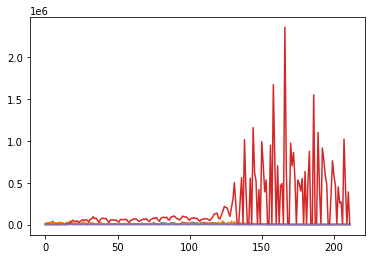

In [9]:
plt.plot(data_germany)

# Data Generator for Neural Net

In [10]:
def data_generator(batch_size, T=None, N=None, T_min=10, T_max=90, sim_diff=21,
                   N_min=10000, N_max=70000000, to_tensor=True, seed=None):
    """
    Runs the forward model 'batch_size' times by first sampling from the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    simulator  : callable -- the data simulator
    to_tensor  : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    if seed is not None:
        np.random.seed(seed)
        
    # Variable-size t
    if T is None:
        T = np.random.randint(T_min, T_max+1)
    
    # Variable size N
    if N is None:
        N = np.random.randint(N_min, N_max)
        
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    x = []
    theta = []
    for i in range(batch_size):
        
        # Reject meaningless simulations
        x_i = None
        while x_i is None:
            try:
                theta1 = prior_sir()
                theta2 = prior_secir()
                x_i = SECIR(theta1, theta2, N, T, sim_diff=sim_diff)
                #print("x_i returned")
                x_i = (x_i - mean_g) / std_g
            except:
                pass
        # Simulate SECIR
        x.append(x_i)
        theta.append(theta1 + theta2)
    x = np.array(x)

    # Convert to tensor, if specified 
    if to_tensor:
        theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
    return {'theta': theta,  'x': x}

# Training Hyperparameters

In [11]:
# Network hyperparameters
inv_meta = {
    'n_units': [192, 192, 192],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_summary = 192
n_inv_blocks = 6

param_names = [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$',
               r'$\lambda_0$', r'$\lambda_1$', r'$\lambda_2$', r'$\lambda_3$', r'$\lambda_4$', 
               r'$\mu$', r'$\mu_v$', r'$f_I$', r'$\phi_I$',  r'$f_R$', r'$\phi_R$',  
               r'$f_D$', r'$\phi_D$', r'$f_V$', r'$\phi_V$', r'$f_T$', r'$\phi_T$',  
               r'$D_I$', r'$D_R$', r'$D_D$', r'$D_V$', r'$D_T$', r'$E_0$', r'$C_0$', 
               r'$\sigma_I$', r'$\sigma_R$', r'$\sigma_D$', r'$\sigma_V$', r'$\sigma_T$', 
               r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', 
               r'$\alpha$', r'$\alpha_v$', r'$\beta$', r'$\beta_v$', r'$\gamma$',
               r'$\eta$', r'$\theta$', r'$\delta$', r'$\delta_v$', r'$d$',
               r'$\epsilon$', r'$\tau$']

theta_dim = len(param_names)
n_test = 30

# Training and optimizer hyperparameters
ckpt_file = "Germany"
batch_size = 64
epochs = 10 # 75
iterations_per_epoch = 1000 # 1000
n_samples_posterior = 2000
clip_value = 5.


starter_learning_rate = 0.0005
global_step = tf.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

In [12]:
data_gen = partial(data_generator, T=T, N=N_germany, sim_diff=32)

In [13]:
class MultiConvLayer(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""
    def __init__(self, n_filters=32, strides=1):
        super(MultiConvLayer, self).__init__()
        
        self.convs = [
            tf.keras.layers.Conv1D(n_filters//2, kernel_size=f, strides=strides, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform')
            for f in range(2, 8)
        ]
        self.dim_red = tf.keras.layers.Conv1D(n_filters, 1, 1, 
                                              activation='relu', kernel_initializer='glorot_uniform')
        
    def call(self, x):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        out = tf.concat([conv(x) for conv in self.convs], axis=-1)
        out = self.dim_red(out)
        return out
    
    
class MultiConvNet(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""
    def __init__(self, n_layers=3, n_filters=64, strides=1):
        super(MultiConvNet, self).__init__()
        
        self.net = tf.keras.Sequential([
            MultiConvLayer(n_filters, strides)
            for _ in range(n_layers)
        ])
        
        self.lstm = tf.keras.layers.LSTM(n_filters)
        
    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        out = self.net(x)
        out = self.lstm(out)
        return out
    
    
class SummaryNet(tf.keras.Model):
    def __init__(self, n_summary):
        super(SummaryNet, self).__init__()
        t = 5
        self.net_I = MultiConvNet(n_filters=n_summary//t)
        self.net_R = MultiConvNet(n_filters=n_summary//t)
        self.net_D = MultiConvNet(n_filters=n_summary//t)
        self.net_V = MultiConvNet(n_filters=n_summary//t)
        self.net_T = MultiConvNet(n_filters=n_summary//t)
    
    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        x = tf.split(x, 5, axis=-1)
        x_i = self.net_I(x[0])
        x_r = self.net_R(x[1])
        x_d = self.net_D(x[2])
        x_v = self.net_V(x[3])
        x_t = self.net_T(x[4])
        return tf.concat([x_i, x_r, x_d, x_v, x_t], axis=-1)

In [14]:
summary_net = SummaryNet(n_summary)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

In [15]:
%%time
test_data = data_gen(n_test)

CPU times: user 2.4 s, sys: 608 µs, total: 2.4 s
Wall time: 2.4 s


In [16]:
data_germany_tensor = tf.convert_to_tensor(data_germany[np.newaxis], dtype=tf.float32)

In [17]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, 'drive/MyDrive/AML/checkpoints2/{}/'.format(ckpt_file), max_to_keep=20)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from drive/MyDrive/AML/checkpoints2/Germany/ckpt-1


In [ ]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=maximum_likelihood_loss, 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              clip_value=clip_value,
                              clip_method='global_norm',
                              global_step=global_step)
        
        # Manage checkpoint
        manager.save()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

# Publication figures

## Univariate parameter posteriors

In [ ]:
from sklearn.neighbors import KernelDensity

def estimate_map(samples):
    
    bw = 1.06 * samples.std() * samples.size ** (-1 / 5.)
    scores = KernelDensity(bandwidth=bw).fit(samples.reshape(-1, 1)).score_samples(samples.reshape(-1, 1))
    max_i = scores.argmax()
    map_i = samples[max_i]
    return map_i


def get_kde(samples):
    """Returns sorted kdes."""
    bw = 1.06 * samples.std() * samples.size ** (-1 / 5.)
    kde = KernelDensity(bandwidth=bw).fit(samples.reshape(-1, 1))
    x_plot = np.linspace(samples.min(), samples.max(), 10000)
    y_plot = np.exp(kde.score_samples(x_plot[:, np.newaxis]))
    return x_plot, y_plot

def plot_posteriors_germany(n_samples, 
                            data, 
                            figsize=(22, 12), 
                            font_size=16, 
                            filename=None, 
                            bins=30,
                            map_samples=5000):
    """Plots univariate posteriors."""
    
    # Plot settings
    plt.rcParams['font.size'] = font_size
    norm_data = (data - mean_g) / std_g 
    samples = model.sample(norm_data, n_samples, to_numpy=True)

    idx_nonzero = [i for i, e in enumerate(param_names) if 'phi' not in e]
    samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
    idx_alpha = param_names.index('$\\alpha$')
    print('Number of valid samples: ', samples.shape[0])
    num_rows = theta_dim//6 + 1
    num_columns = 6
    f, ax = plt.subplots(num_rows, num_columns, figsize=figsize)
    for i in range(theta_dim):
        
        x_fill, y_fill = get_kde(prior_samples[:, i])
        ax.flat[i].plot(x_fill, y_fill, alpha=0.5, color='gray', lw=3, label='Prior')
        sns.histplot(samples[:, i], kde=False, bins=bins, ax=ax.flat[i], stat='density',
                     color='#a34f4f', element='step', label='Posterior')
        
        ax.flat[i].spines['right'].set_visible(False)
        ax.flat[i].spines['top'].set_visible(False)
        ax.flat[i].axvline(np.median(samples[:, i]), color='black', linestyle='dashed')
        ax.flat[i].set_title(param_names[i], pad=0.4)
        ax.flat[i].set_ylim([0, ax.flat[i].get_ylim()[1]])
        if i == idx_alpha:
            align = 'right'
            xx = 0.4
        else:
            align = 'left'
            xx = 0.7
            
        # Change points
        if i < 4:
            
            tick_std = np.std(prior_samples[:, i])
            tick_mean = np.mean(prior_samples[:, i])
            ax.flat[i].set_xticks([tick_mean-1.98*tick_std, tick_mean, tick_mean+1.98*tick_std])
            ax.flat[i].set_xticklabels([days[int(round(tick_mean - 1.98*tick_std))], 
                                        days[int(round(tick_mean))], 
                                        days[int(round(tick_mean + 1.98*tick_std))]], rotation=30)
            
        if i == 0:
            lg = f.legend(loc='lower right', bbox_to_anchor=(0.9, 0.04), 
                     ncol=2, fontsize=20, borderaxespad=1)
            
        med = np.median(samples[:, i])
        MAP = estimate_map(samples[:map_samples, i])
        ax.flat[i].text(xx, 0.85, r'$MAP={:.2f}$'.format(MAP),
                     horizontalalignment=align,
                     verticalalignment='center',
                     transform=ax.flat[i].transAxes,
                     size=12)
        ax.flat[i].text(xx, 0.6, r'$Med={:.2f}$'.format(med),
                     horizontalalignment=align,
                     verticalalignment='center',
                     transform=ax.flat[i].transAxes,
                     size=12)
        
        ax.flat[i].set_ylabel('')
        ax.flat[i].set_yticks([])
    
    for j in range(theta_dim, num_rows*num_columns):
        ax.flat[j].axis('off')
    f.tight_layout()
    plt.show()
    
     # Save if specified
    if filename is not None:
        f.savefig("figures/{}.png".format(filename), dpi=300,  
                  bbox_extra_artists=(lg,), bbox_inches='tight')

In [19]:
days = ['January {}'.format(i) for i in range(1,32)] + \
       ['February {}'.format(i) for i in range(1, 29)] + \
       ['March {}'.format(i) for i in range(1, 32)] + \
       ['April {}'.format(i) for i in range (1, 31)] + \
       ['May {}'.format(i) for i in range(1, 32)] + \
       ['June {}'.format(i) for i in range(1, 31)] + \
       ['July {}'.format(i) for i in range(1, 32)] + \
       ['August {}'.format(i) for i in range(1, 32)] + \
       ['September {}'.format(i) for i in range(1, 31)] 

In [20]:
n_prior_samples = 5000
prior_samples = np.array([prior_sir() + prior_secir() for _ in range(n_prior_samples)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
Number of valid samples:  0


FloatingPointError: ignored

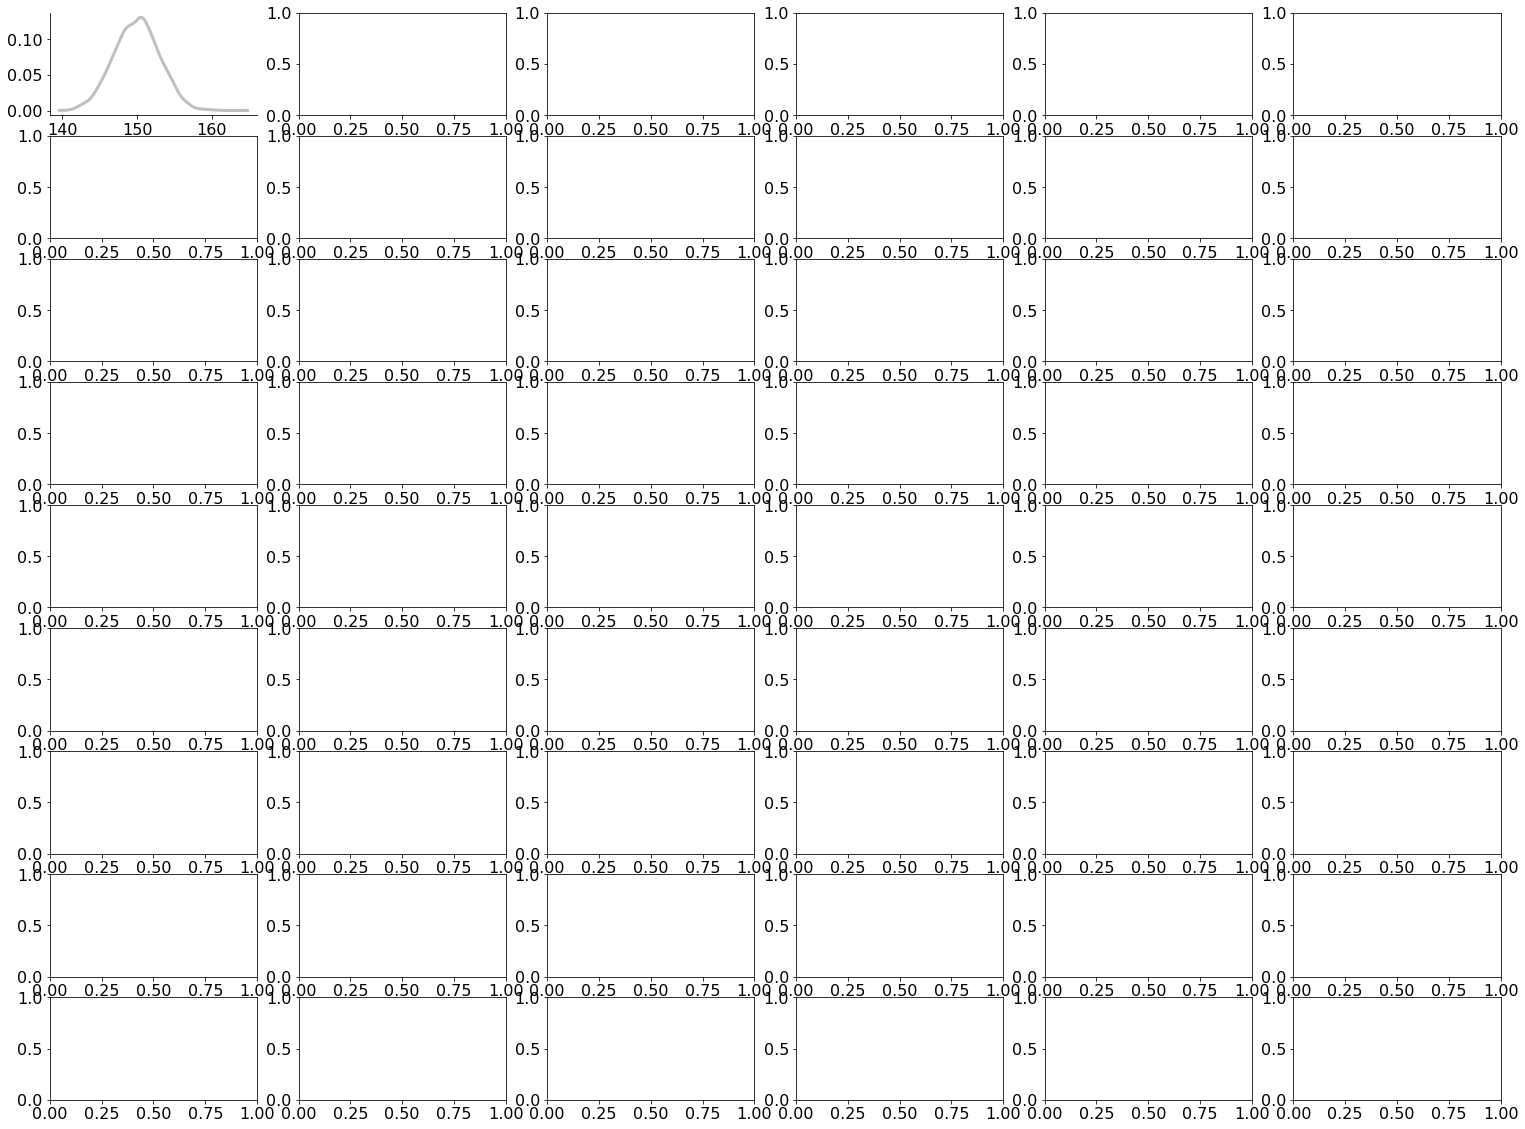

In [21]:
plot_posteriors_germany(150000, 
                        data_germany_tensor, 
                        bins=50, figsize=(26, 20), 
                        filename='Marginal_Posteriors_Germany', 
                        map_samples=1000)

## Tables

In [22]:
param_tex = ['$t_1$', '$t_2$', '$t_3$', '$t_4$',
               '$\lambda_0$', '$\lambda_1$', '$\lambda_2$', '$\lambda_3$', '$\lambda_4$', 
               '$\mu$', '$f_I$', '$\phi_I$',  '$f_R$', '$\phi_R$',  
               '$f_D$', '$\phi_D$', '$f_V$', '$\phi_V$', '$f_T$', '$\phi_T$',
               '$D_I$', '$D_R$', '$D_D$', '$D_V$', '$D_T$', '$E_0$', '$C_0$', 
               '$\sigma_I$', '$\sigma_R$', '$\sigma_D$', '$\sigma_V$', '$\sigma_T$', 
               '$v_1$', '$v_2$', '$v_3$', '$v_4$', 
               '$\alpha$', '$\alpha_v$', '$\beta$', '$\beta_v$', '$\gamma$',
               '$\eta$', '$\theta$', '$\delta$', '$\delta_v$', r'$d$',
               '$\epsilon$', '$\tau$']

In [23]:
def create_table(data, model, n_samples=1000000, map_samples=10000):
    """Prepares a table with posterior summaries."""
    
    
    norm_data = (data_germany_tensor - mean_g) / std_g 
    samples = model.sample(norm_data, n_samples, to_numpy=True)
    idx_nonzero = [i for i, e in enumerate(param_names) if 'phi' not in e]
    samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
    idx_alpha = param_names.index('$\\alpha$')
    print('Number of valid samples: ', samples.shape[0])  
    
    # Compute quantiles and medians
    qs_95 = np.quantile(samples, q=[0.025, 0.975], axis=0)
    qs_95_str = ['[{0:.3f} - {1:.3f}]'.format(qs_95[0, i], qs_95[1, i]) for i in range(len(param_names))]
    meds = np.array(['{0:.3f}'.format(m) for m in np.median(samples, axis=0)])
    means = np.array(['{0:.3f}'.format(m) for m in np.mean(samples, axis=0)])
    maps = np.array(['{0:.3f}'.format(estimate_map(samples[:map_samples, i])) for i in range(len(param_names))])
    
    # Prepare table
    table = pd.DataFrame(index=param_tex, data={'Median': meds, 'Mean': means, 'MAP': maps, '95-CI': qs_95_str})
    return table

In [24]:
t = create_table(data_germany_tensor, model)

Number of valid samples:  0


IndexError: ignored

In [ ]:
print(t.to_latex(escape=False))

## Simulation-based calibration

In [ ]:
def plot_sbc(theta_samples, theta_test, param_names, bins=25,
            figsize=(24, 12), interval=0.99, show=True, filename=None, font_size=12):
    """
    Plots the simulation-based posterior checking histograms as advocated by Talts et al. (2018).
    """

    # Plot settings
    plt.rcParams['font.size'] = font_size
    N = int(theta_test.shape[0])
    
    num_rows = len(param_names)//6 + 1
    num_columns = 6
    f, axarr = plt.subplots(num_rows, num_columns, figsize=figsize)
    axarr = axarr.flat

    # Convert theta test to numpy
    theta_test = theta_test.numpy()

    # Compute ranks (using broadcasting)    
    ranks = np.sum(theta_samples < theta_test, axis=0)
    
    # Compute interval
    endpoints = binom.interval(interval, N, 1 / (bins+1))

    # Plot histograms
    for j in range(len(param_names)):
        
        
        # Add interval
        axarr[j].axhspan(endpoints[0], endpoints[1], facecolor='gray', alpha=0.3)
        axarr[j].axhline(np.mean(endpoints), color='gray', zorder=0, alpha=0.5)
        
        sns.distplot(ranks[:, j], kde=False, ax=axarr[j], color='#a34f4f',
                         hist_kws=dict(edgecolor="k", linewidth=1,alpha=1.), bins=bins)
        
        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
        if j == 0:
            axarr[j].set_xlabel('Rank statistic')
        axarr[j].get_yaxis().set_ticks([])
    
    for j in range(len(param_names), num_rows*num_columns):
        axarr[j].axis('off')
    f.tight_layout()
    
    # Show, if specified
    if show:
        plt.show()
        
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}_Entire.png".format(filename), dpi=300)

In [ ]:
test_data_sbc = data_gen(5000)
theta_samples = np.concatenate([model.sample(x, 250, to_numpy=True) 
                                for x in tf.split(test_data_sbc['x'], 10, axis=0)], axis=1)

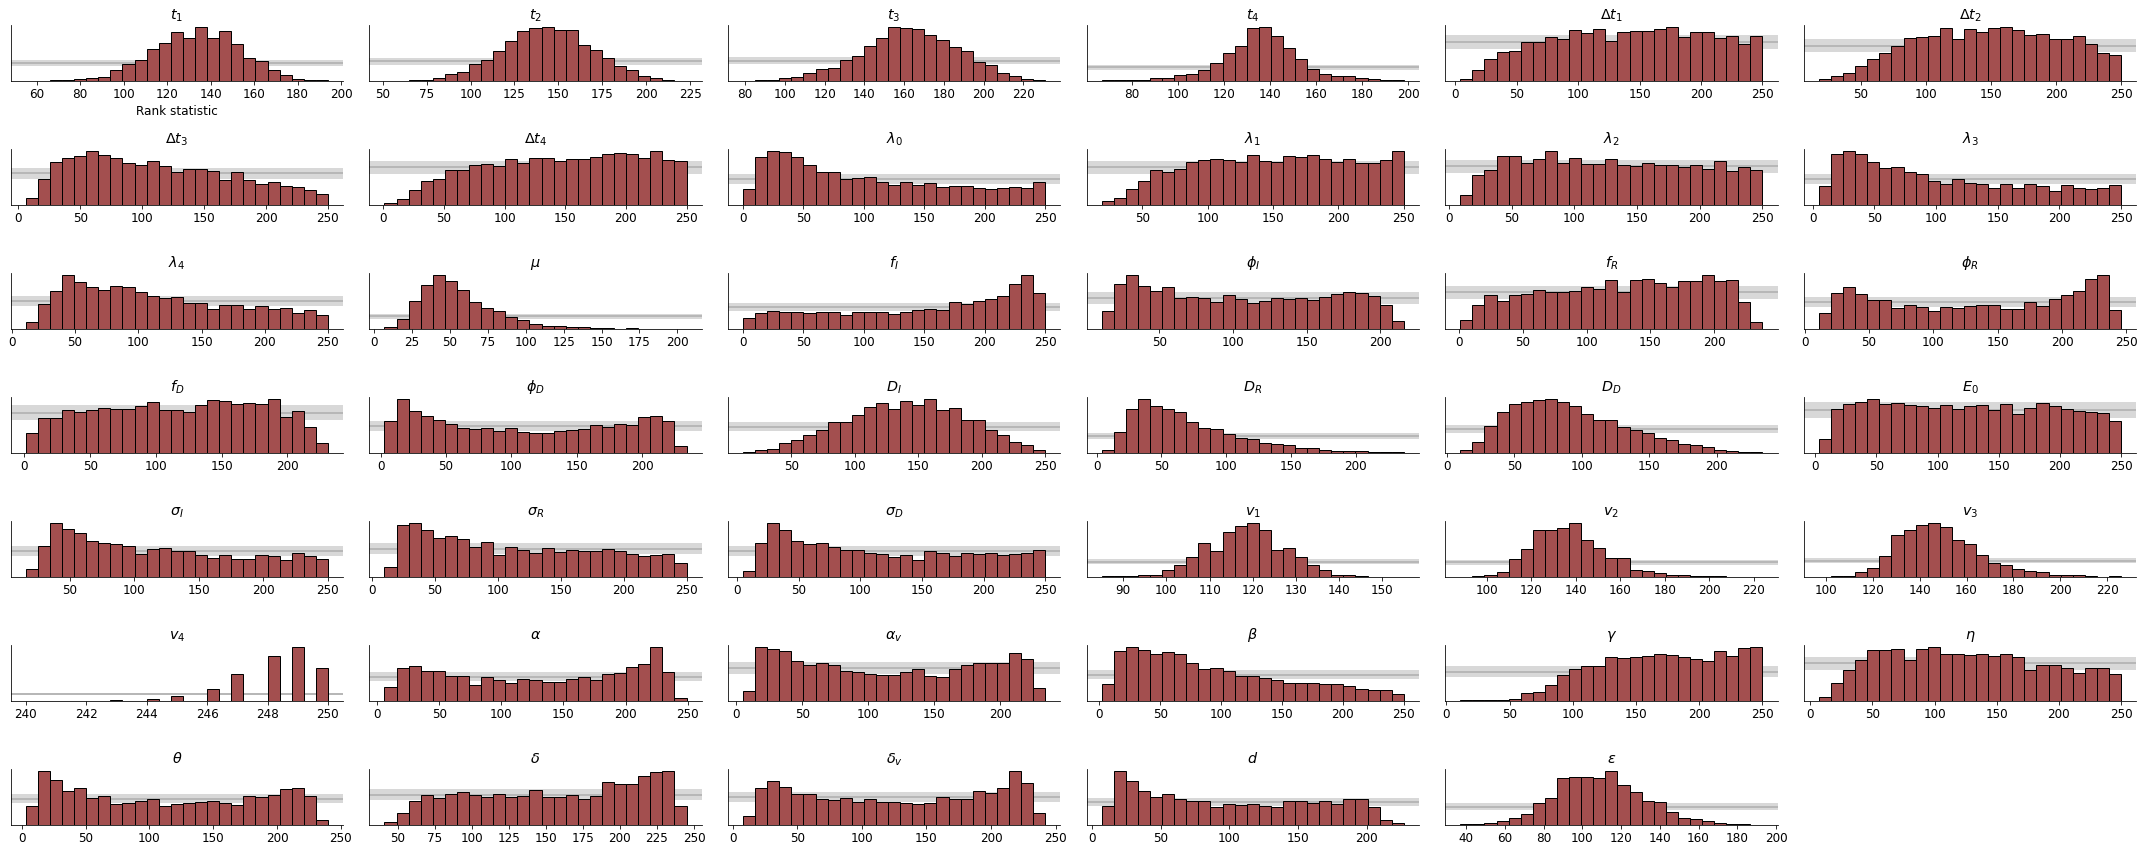

In [ ]:
plot_sbc(theta_samples, 
         test_data_sbc['theta'], 
         param_names, 
         bins=25,
         figsize=(30, 12), 
         filename='SBC')

## Asymptomatic predictions

In [ ]:
def plot_asymptomatic(n_samples, 
                     data, 
                     N_sim, 
                     logscale=True, 
                     sim_diff=16, 
                     plot_quantiles=True, 
                     figsize=(24, 8), 
                     filename=None,
                     font_size=18):
    """Plots the posterior predictive."""
    
    # Plot settings
    plt.rcParams['font.size'] = font_size
    
    norm_data = (data - mean_g) / std_g 
    samples = model.sample(norm_data, n_samples, to_numpy=True)
    idx_nonzero = [i for i, e in enumerate(param_names) if 'phi' not in e]
    samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
    print('Number of valid samples: ', samples.shape[0])
    idx_alpha = param_names.index('$\\alpha$')
    f, ax = plt.subplots(1, 1, figsize=figsize)
    sims_A = []
    sims_S = []
    rej = 0
    for i in range(samples.shape[0]): 
        try:
            sim_A, sim_S = SECIR(samples[i, :idx_alpha], samples[i, idx_alpha:], N_sim, T, sim_diff=sim_diff, asymptomatic=True)
            sims_A.append(sim_A)
            sims_S.append(sim_S)
        except:
            rej += 1
    sims_A = np.array(sims_A)
    sims_S = np.array(sims_S)
    print('Number of rejected simulations: ', rej)

    sims_A = np.cumsum(sims_A, axis=1)
    sims_S = np.cumsum(sims_S, axis=1)
    meds_A = np.median(sims_A, axis=0)
    meds_S = np.median(sims_S, axis=0)

    title = 'Symptomatic (detected) vs. asymptomatic (detected or undetected)'
    colors = ['#041bc7', '#c75804']
    
    # Compute quantiles
    qs_50_A = np.quantile(sims_A, q=[0.25, 0.75], axis=0)
    qs_90_A = np.quantile(sims_A, q=[0.05, 0.95], axis=0)
    qs_95_A = np.quantile(sims_A, q=[0.025, 0.975], axis=0)
    
    # Compute quantiles
    qs_50_S = np.quantile(sims_S, q=[0.25, 0.75], axis=0)
    qs_90_S = np.quantile(sims_S, q=[0.05, 0.95], axis=0)
    qs_95_S = np.quantile(sims_S, q=[0.025, 0.975], axis=0)
    
    
    # Plot medians
    ax.plot(meds_S, label='Predicted symptomatic', color=colors[0], lw=3)
    ax.plot(meds_A, label='Predicted asymptomatic ', color=colors[1], lw=3)
        
    if plot_quantiles:
        ax.fill_between(range(meds_S.shape[0]), qs_50_S[0, :], qs_50_S[1, :], color=colors[0], alpha=0.3, label='50% CI')
        ax.fill_between(range(meds_S.shape[0]), qs_90_S[0, :], qs_90_S[1, :], color=colors[0], alpha=0.2, label='90% CI')
        ax.fill_between(range(meds_S.shape[0]), qs_95_S[0, :], qs_95_S[1, :], color=colors[0], alpha=0.1, label='95% CI')
        
        ax.fill_between(range(meds_S.shape[0]), qs_50_A[0, :], qs_50_A[1, :], color=colors[1], alpha=0.3, label='50% CI')
        ax.fill_between(range(meds_S.shape[0]), qs_90_A[0, :], qs_90_A[1, :], color=colors[1], alpha=0.2, label='90% CI')
        ax.fill_between(range(meds_S.shape[0]), qs_95_A[0, :], qs_95_A[1, :], color=colors[1], alpha=0.1, label='95% CI')
    ax.spines['right'].set_visible(False)
    ax.set_title(title, pad=0.2)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Days')
    ax.set_ylabel('Number of cases')
    ax.legend(loc='upper left')
    ax.set_ylim([0, np.max(qs_95_A[1, :])*1.1])
    if logscale:
        ax.set_yscale('log')
    f.tight_layout()
    plt.show()
    
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}.png".format(filename), dpi=300)

Number of valid samples:  0
Number of rejected simulations:  0


AxisError: ignored

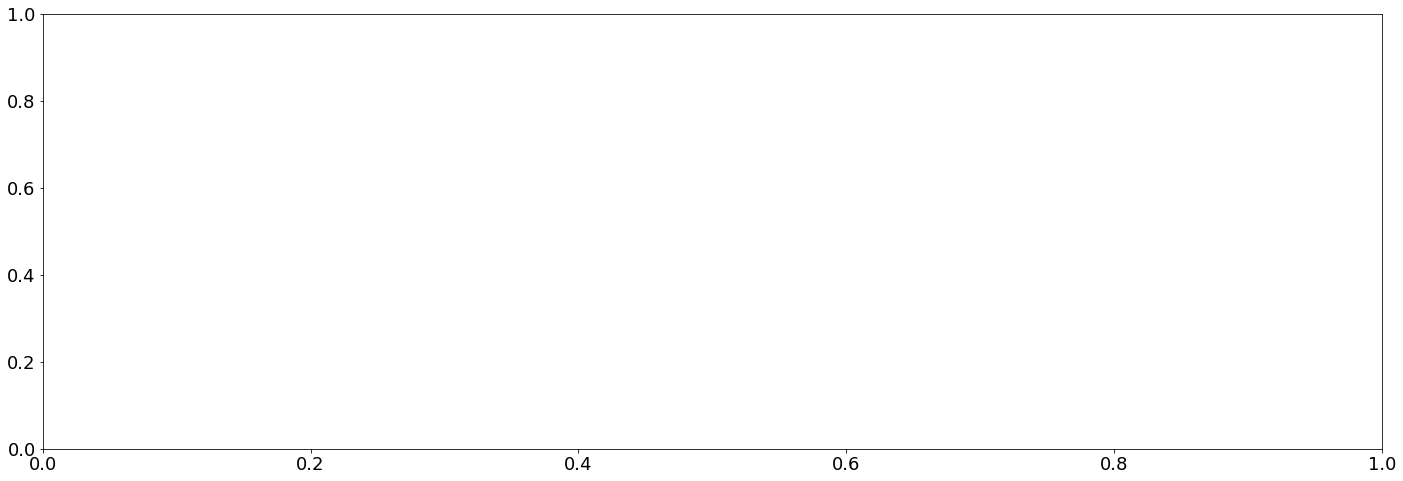

In [ ]:
plot_asymptomatic(500000,
                  data_germany_tensor,
                  N_germany,
                  logscale = False)

## Predictions on future data

In [ ]:
def plot_predictions_future(n_samples, 
                            data, 
                            data_pred,
                            N_sim, 
                            T,
                            logscale=True, 
                            sim_diff=16, 
                            plot_quantiles=True, 
                            figsize=(24, 8), 
                            cumulative=False,
                            filename=None,
                            font_size=18,
                            D=4):
    """Plots the posterior predictive."""
    
    # Plot settings
    plt.rcParams['font.size'] = font_size
    
    norm_data = (data - mean_g) / std_g 
    valid_samples = np.empty((0,0))
    t = 0
    while (valid_samples.shape[0] < n_samples):

        print(t)
        t+=1

        samples = model.sample(norm_data, n_samples, to_numpy=True)
        idx_nonzero = [i for i, e in enumerate(param_names) if 'phi' not in e]
        samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
        if (valid_samples.shape[0] == 0):
            valid_samples = samples
        else:
            valid_samples = np.concatenate((valid_samples, samples))
            
    print('Number of valid samples: ', samples.shape[0])
    f, ax = plt.subplots(1, D, figsize=figsize)
    sims = []
    rej = 0
    for i in range(samples.shape[0]): 
        try:
            sim_cases = SECIR(samples[i, :-10], samples[i, -10:], N_sim, T, sim_diff=sim_diff)
            sims.append(sim_cases)
        except:
            rej += 1
    sims = np.array(sims)
    print('Number of rejected simulations: ', rej)
    
    if cumulative:
        sims = np.cumsum(sims, axis=1)
    meds = np.median(sims, axis=0)
    if cumulative:
        titles = ['Cumulative Infected', 'Cumulative Recovered', 'Cumulative Dead', 'Cumulative Vaccinations']
    else:
        titles = ['New Infected', 'New Recovered', 'New Dead', 'New Vaccinations']
        
    colors = ['Blue', 'Green', '#911a20', 'Orange']
    
    # Compute quantiles
    qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)
    
    
    for i in range(D):
        if cumulative:
            ax[i].plot(np.cumsum(data_pred[:, i], axis=0), 
                       marker='o', label='Reported cases', color='black', linestyle='dashed', alpha=0.8)
        else:
            ax[i].plot(data_pred[:, i], marker='o', 
                       label='Reported cases', 
                       color='black', linestyle='dashed', alpha=0.8)
        
        ax[i].axvline(data.numpy()[0, :, i].shape[0], color='black', alpha=0.8, linestyle='dashed')
        
        # Plot median cases
        ax[i].plot(meds[:, i], label='Median predicted cases', color=colors[i], lw=3)
        
        if plot_quantiles:
            ax[i].fill_between(range(T), qs_50[0, :, i], qs_50[1, :, i], color=colors[i], alpha=0.3, label='50% CI')
            ax[i].fill_between(range(T), qs_90[0, :, i], qs_90[1, :, i], color=colors[i], alpha=0.2, label='90% CI')
            ax[i].fill_between(range(T), qs_95[0, :, i], qs_95[1, :, i], color=colors[i], alpha=0.1, label='95% CI')
        ax[i].spines['right'].set_visible(False)
        ax[i].set_title(titles[i], pad=0.2)
        ax[i].spines['top'].set_visible(False)
        ax[i].set_xlabel('Days')
        ax[i].set_ylabel('Number of cases')
        ax[i].legend(loc='upper left')
        ax[i].set_ylim([0, np.max(qs_95[1, :, i])*1.5])
        ticks = np.arange(6, T, 14)
        ax[i].set_xticks(ticks)
        ax[i].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
        ax[i].set_xticklabels(np.array(days)[ticks], rotation=45)
        ylabels = ['{:,.1f}'.format(x) + 'K' for x in ax[i].get_yticks()/1000]
        ax[i].set_yticklabels(ylabels)
        
        if logscale:
            ax[i].set_yscale('log')
    f.tight_layout()
    plt.show()
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}.png".format(filename), dpi=300)

In [ ]:
#date_data_begin = datetime.date(2020,3,1)
date_data_end_f = datetime.date(2021,9,1)


format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
date_formatted_begin = format_date(date_data_begin)
date_formatted_end_f = format_date(date_data_end_f)

cases_obs_f =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end_f])[0]
recovered_obs_f =  np.array(
    recovered_cases.loc[recovered_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end_f])[0]
dead_obs_f =  np.array(
    dead_cases.loc[dead_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end_f])[0]

# filter the vaccinations according to the start and end date
vaccinated_f = vaccinations[(vaccinations["Country_Region"] == "Germany") & 
                          (pd.to_datetime(vaccinations["Date"]) >= pd.to_datetime(date_data_begin)) &
                          (pd.to_datetime(vaccinations["Date"]) <= pd.to_datetime(date_data_end))]
# filter only the column of fully vaccinated persons
vaccinated_f = np.array(vaccinated_f)[:,4]
vaccinated_f = np.concatenate([np.zeros(cases_obs_f.shape[0] - vaccinated_f.shape[0]), vaccinated_f]).astype(int)

data_germany_f = np.stack([cases_obs_f, recovered_obs_f, dead_obs_f, vaccinated_f]).T
data_germany_f = np.diff(data_germany_f, axis=0)
T_f = data_germany_f.shape[0]

In [ ]:
plot_predictions_future(10, 
                 data_germany_tensor, 
                 data_germany_f,
                 N_germany, 
                 T_f,
                 logscale=False, 
                 sim_diff=16, 
                 cumulative=True, 
                 figsize=(36, 10), 
                 font_size=22,
                 filename='Predicted_Cumulative_Uninformative')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/dist-packages/keras/backend.py", line 4495, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/u

KeyboardInterrupt: ignored

Number of valid samples:  8
Number of rejected simulations:  3


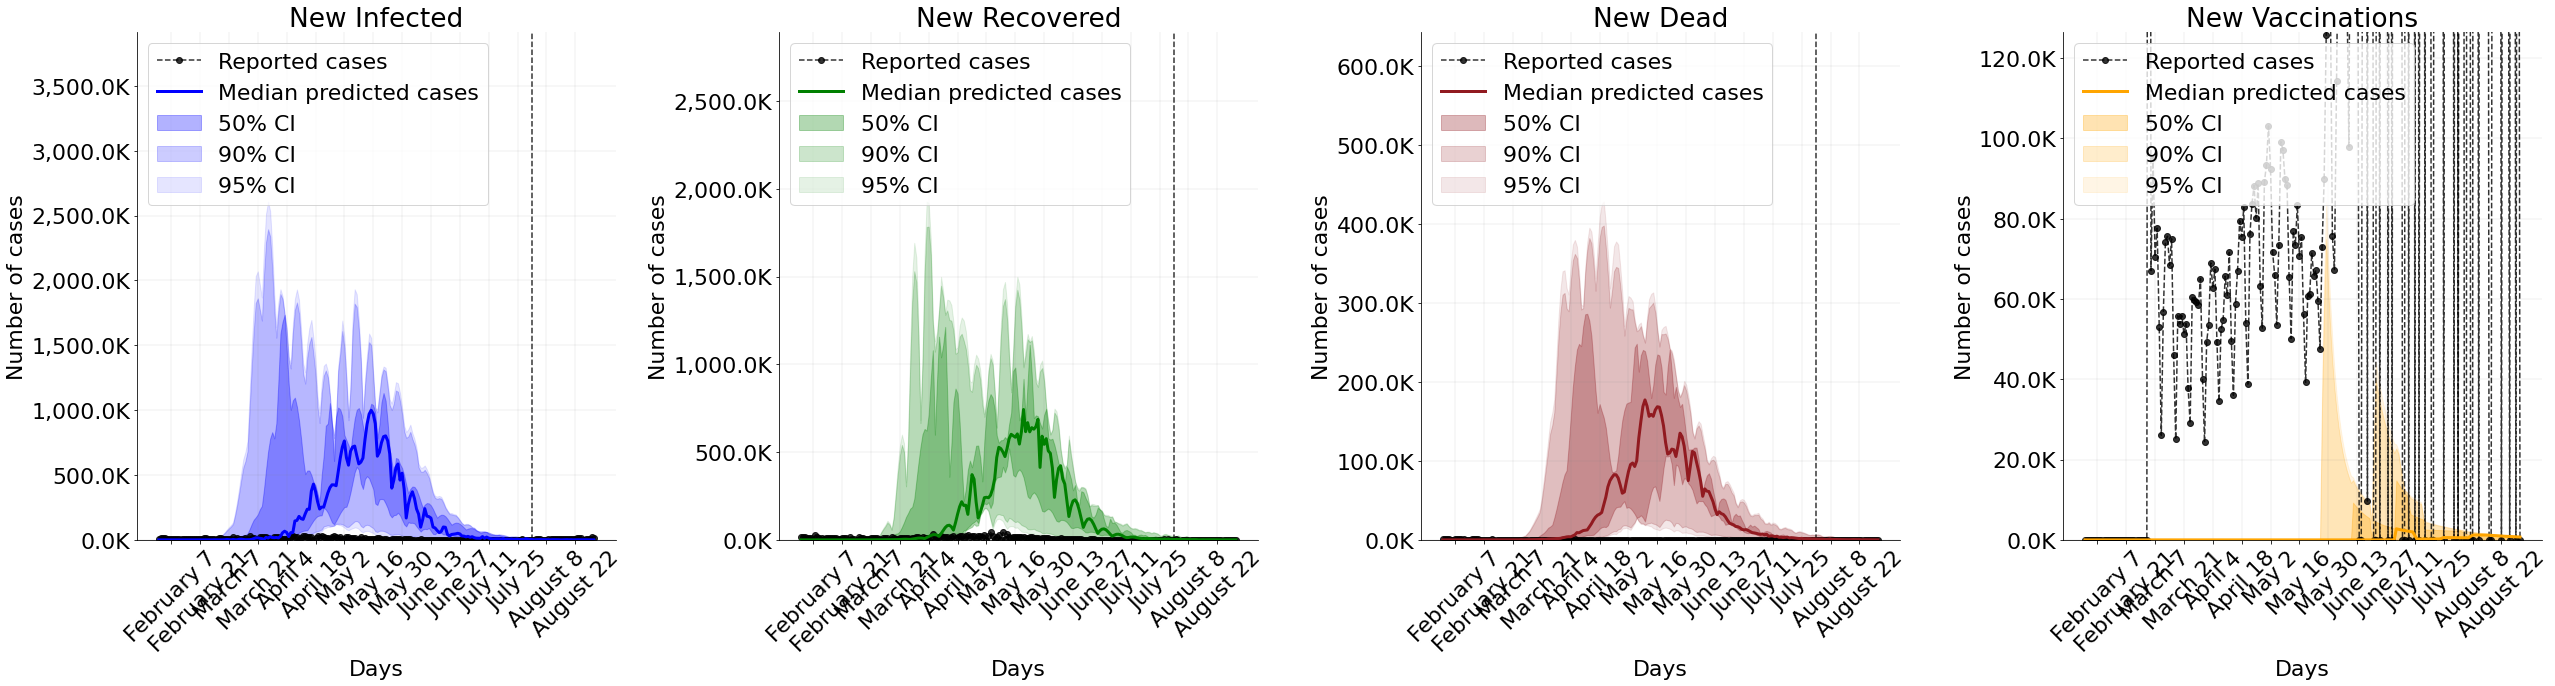

In [ ]:
plot_predictions_future(50000, 
                 data_germany_tensor, 
                 data_germany_f,
                 N_germany, 
                 T_f,
                 logscale=False, 
                 sim_diff=16, 
                 cumulative=False, 
                 figsize=(36, 10), 
                 font_size=22,
                 filename='Predicted_New_Uninformative')

## R_0

In [ ]:
def calc_lambdas(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4, 
                 t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, T):
    """Computes the array of time-varying contact rates/transimission probabilities."""

    
    
    # Array of initial lambdas
    lambd0_arr = np.array([lambd0] * (t1+sim_lag))
    
    # Compute lambd1 array
    if delta_t1 == 1:
        lambd1_arr = np.array([lambd1] * (t2-t1))
    else:
        lambd1_arr = np.linspace(lambd0, lambd1, delta_t1)
        lambd1_arr = np.append(lambd1_arr, [lambd1] * (t2-t1-delta_t1))
        
    # Compute lambd2 array
    if delta_t2 == 1:
        lambd2_arr = np.array([lambd2] * (t3-t2))
    else:
        lambd2_arr = np.linspace(lambd1, lambd2, delta_t2)
        lambd2_arr = np.append(lambd2_arr, [lambd2] * (t3-t2-delta_t2))
        
    # Compute lambd3 array
    if delta_t3 == 1:
        lambd3_arr = np.array([lambd3] * (t4-t3))
    else:
        lambd3_arr = np.linspace(lambd3, lambd4, delta_t3)
        lambd3_arr = np.append(lambd3_arr, [lambd3] * (t4-t3-delta_t3))
        
    # Compute lambd4 array
    if delta_t4 == 1:
        lambd4_arr = np.array([lambd4] * (T-t4))
    else:
        lambd4_arr = np.linspace(lambd3, lambd4, delta_t4)
        lambd4_arr = np.append(lambd4_arr, [lambd4] * (T-t4-delta_t4))
    
    return np.r_[lambd0_arr, lambd1_arr, lambd2_arr, lambd3_arr, lambd4_arr]


def compute_r0_over_time(data, model, n_samples, sim_diff, T):
    """
    Computes R0 over time.
    """
    
    sim_lag = sim_diff - 1
    norm_data = (data - mean_g) / std_g 
    param_samples = model.sample(norm_data, n_samples, to_numpy=True)
    idx_nonzero = [i for i, e in enumerate(param_names) if e != '$\\phi_I$' and e != '$\\phi_D$' and e != '$\\phi_R$']
    param_samples = param_samples[np.sum(param_samples[:, idx_nonzero] < 0, axis=1) == 0]
    
    print('Number of valid samples: ', param_samples.shape[0])
    
    # Extract parameters
    t1 = param_samples[:, 0]
    t2 = param_samples[:, 1]
    t3 = param_samples[:, 2]
    t4 = param_samples[:, 3]
    
    delta_t1 = param_samples[:, 4]
    delta_t2 = param_samples[:, 5]
    delta_t3 = param_samples[:, 6]
    delta_t4 = param_samples[:, 7]
    
    lambd0 = param_samples[:, 8]
    lambd1 = param_samples[:, 9]
    lambd2 = param_samples[:, 10]
    lambd3 = param_samples[:, 11]
    lambd4 = param_samples[:, 12]
    
    delay_i = param_samples[:, 20]
    delay_r = param_samples[:, 21]
    delay_d = param_samples[:, 22]
    
    mu = param_samples[:, 13]
    alpha = param_samples[:, 27]
    beta = param_samples[:, 28]
    gamma = param_samples[:, 29]
    eta = param_samples[:, 30]
    theta = param_samples[:, 31]
    delta = param_samples[:, 32]
    d = param_samples[:, 33]

    # Convert integer parameters
    # Round integer parameters
    t1, t2, t3, t4 = np.round(t1).astype(np.int32), np.round(t2).astype(np.int32), np.round(t3).astype(np.int32), np.round(t4).astype(np.int32)
    delta_t1, delta_t2 = np.round(delta_t1).astype(np.int32), np.round(delta_t2).astype(np.int32)
    delta_t3, delta_t4 = np.round(delta_t3).astype(np.int32), np.round(delta_t4).astype(np.int32)
    delay_i = np.round(delay_i).astype(np.int32)
    delay_r = np.round(delay_r).astype(np.int32)
    delay_d = np.round(delay_d).astype(np.int32)
    
    R0s = []
    # Calculate R0 with uncertainty
    for i in range(param_samples.shape[0]):
        R0 = []
        try:
            #print("Assert")
            assert sim_diff > delay_i[i]
            assert sim_diff > delay_r[i]
            assert sim_diff > delay_d[i]
            assert t1[i] > 0 and t2[i] > 0 and t3[i] > 0 and t4[i] > 0
            assert t1[i] < t2[i] < t3[i] < t4[i]
            assert delta_t1[i] > 0 and delta_t2[i] > 0 and delta_t3[i] > 0 and delta_t4[i] > 0
            assert t2[i] - t1[i] >= delta_t1[i] and t3[i] - t2[i] >= delta_t2[i] and t4[i]-t3[i] >= delta_t3[i] and T-t4[i] >= delta_t4[i]
            #print("Assertions passed")
            lambda_ts = calc_lambdas(sim_lag, 
                                     lambd0[i], 
                                     lambd1[i], 
                                     lambd2[i], 
                                     lambd3[i], 
                                     lambd4[i], 
                                     t1[i], t2[i], t3[i], t4[i], 
                                     delta_t1[i], delta_t2[i], delta_t3[i], delta_t4[i], T)
            
            alpha_i = np.clip(alpha[i], 0.0, 0.99)
            for lambda_t in lambda_ts:
                
        

                denom1 = (1-alpha_i)*eta[i] + alpha_i*theta[i]
                denom2 = (1-delta[i])*mu[i] + delta[i]*d[i]
                R0_t = lambda_t / denom1
                R0_t += (lambda_t*beta[i]*(1-alpha_i)*eta[i]) / (denom1*denom2)
#                 R0_t = lambda_t * ( (beta[i]*(1-alpha_i)*eta[i]) + (1-delta[i])*mu[i] )
#                 R0_t = R0_t / ( ((1-alpha_i)*eta[i] + alpha_i*theta[i]) * (1-delta[i])*mu[i] )
                R0.append(R0_t)
                #print(R0)
            R0s.append(np.array(R0))

        except AssertionError as err:
            pass

    return np.array(R0s)[:, sim_diff:]

In [ ]:
R0s = compute_r0_over_time(data_germany_tensor, model, 10000, sim_diff=16, T=T)

[ 0.48095244 -0.19005778 -1.5034492  -0.16550969  0.9997023  -0.6501896
  1.5332168  -1.2951585  -0.49920022  0.38024372  0.3201618  -1.1501044
 -1.3729402  -1.0037385   0.57102007 -0.7523044  -0.25761253 -0.2846049
 -0.63132375 -0.11082169  0.96429825 -1.5306567  -1.2533504  -0.2076615
 -0.25542486  1.2880771  -0.37593618 -2.1827424  -0.6504953  -0.25519997
 -0.05872867 -1.349677   -0.04524563  0.2039327   0.7619696  -0.6380233
 -1.4688655   0.9847102   0.87940454]
Number of valid samples:  6


In [ ]:
R0_med = np.median(R0s, axis=0)
qs_50 = np.quantile(R0s, q=[0.25, 0.75], axis=0)
qs_90 = np.quantile(R0s, q=[0.05, 0.95], axis=0)
qs_95 = np.quantile(R0s, q=[0.025, 0.975], axis=0)

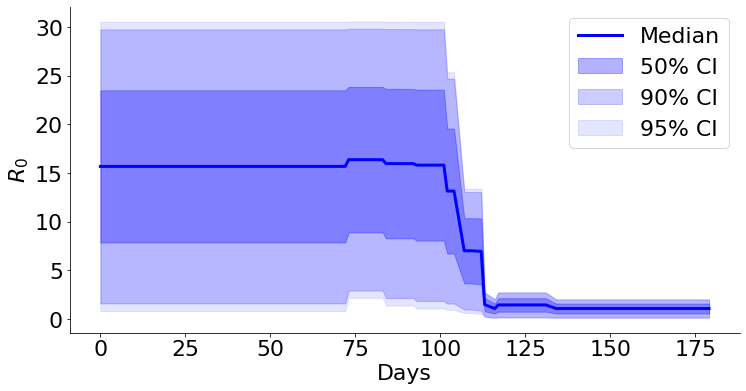

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(R0_med, label='Median', lw=3, color='blue')
ax.fill_between(range(R0_med.shape[0]), qs_50[0, :], qs_50[1, :], color='blue', alpha=0.3, label='50% CI')
ax.fill_between(range(R0_med.shape[0]), qs_90[0, :], qs_90[1, :], color='blue', alpha=0.2, label='90% CI')
ax.fill_between(range(R0_med.shape[0]), qs_95[0, :], qs_95[1, :], color='blue', alpha=0.1, label='95% CI')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Days')
ax.set_ylabel(r'$R_{0}$')
ax.legend()